In [30]:
import numpy as np
import networkx as nx
from edge_fetch import edge_terrier
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import normalize
from featureAnalysis import featureSelection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib
from sklearn.cluster import MiniBatchKMeans

In [51]:
##### Functions ######

##### Features ######

def getEigenVectorCentralityFeatures(graphList, numFeatures):
    # Eigen vector centrality is calculated using the sklearn function
    # The numFeatures chosen are selected based on the largest values
    # Largest values is determined by averaging the values for a node across all subjects
    # The numFeatures highest averages are used to select the features
    featureObj = featureSelection(graphList)
    X = featureObj.eigenvectorCentrality(numFeatures)
    mat = np.matrix(X, dtype = float)
    with open('outfileMat.txt','wb') as f:
        for line in mat:
            np.savetxt(f, line, fmt='%.2f')
    print("Feature matrix of shape", mat.shape, "outputted. Run Urerf in R now.")
    return mat
    
def getKHOPFeatures(graphList, numFeatures):
    # Khop values are calculated using the networkx function
    # The values are calculated for 1 hop and 2 hops for each node
    # The numFeatures chosen are selected based on the highest variance values
    featureObj = featureSelection(graphList)
    X = featureObj.getKhopFeatMat1(numFeatures)
    mat = np.matrix(X, dtype = float)
    with open('outfileMat.txt','wb') as f:
        for line in mat:
            np.savetxt(f, line, fmt='%.2f')
    print("Feature matrix of shape", mat.shape, "outputted. Run Urerf in R now.")
    return mat

###### Plotting #####
    
def graph2D(mat, correctLabels):
    fig = plt.figure(3, figsize=(10, 10))
    fig.suptitle("Visualization of Clustered HNU Data (dwi)", fontsize=20)
    ax = plt.Axes(fig, rect=[0, 0, .5, .5])
    z = list(correctLabels)
    N = len(mat[:,1])
    x = [mat[:,0]]
    y = [mat[:,1]]
    cmap = matplotlib.cm.get_cmap('plasma')
    normalize = matplotlib.colors.Normalize(vmin=min(z), vmax=max(z))
    colors = [cmap(normalize(value)) for value in z]
    plt.scatter(x, y, color = colors)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
def graph3D(mat, correctLabels):
    fig = plt.figure(3, figsize=(10, 10))
    fig.suptitle("Visualization of Clustered HNU Data (dwi)", fontsize=20)
    ax = Axes3D(fig, rect=[0, 0, .5, .5], elev=40, azim=150)
    ax.scatter(mat[:, 0], mat[:, 1], mat[:, 2], c=correctLabels, cmap = "plasma")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
def graph2DLabels(mat, labels):
    fig = plt.figure(3, figsize=(10, 10))
    ax = plt.Axes(fig, rect=[0, 0, .5, .5])
    z = list(labels)
    N = len(mat[:,1])
    x = [mat[:,0]]
    y = [mat[:,1]]
    cmap = matplotlib.cm.get_cmap('plasma')
    normalize = matplotlib.colors.Normalize(vmin=min(z), vmax=max(z))
    colors = [cmap(normalize(value)) for value in z]
    plt.scatter(x, y, color = colors)
    plt.title("HBN Eigenvector Centrality - \nJHU Directory all dwi samples")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
def graph3DLabels(mat, labels):
    fig = plt.figure(4, figsize=(10, 10))
    ax = Axes3D(fig, rect=[0, 0, .5, .5], elev=40, azim=150)
    ax.scatter(mat[:, 0], mat[:, 1], mat[:, 2], c=labels, cmap = "plasma")
    ax.set_title("HBN Eigenvector Centrality - \nJHU Directory all dwi samples")
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
##### Clustering ######
def AffinityPropagationClustering(inputMat, dampInit = .4, dampInc = .1, preferenceInit = 0, preferenceInc = .05):
    maxDamp = 0
    maxPre = 0
    maxSil = 0
    pre = preferenceInit
    while pre < 1:
        #vary the preference value
        pre = pre + preferenceInc
        damp = dampInit
        while damp + dampInc <= .95:
            #vary the damping value
            damp = damp + dampInc
            af = AffinityPropagation(damping = damp, preference = pre, affinity="precomputed").fit(inputMat)
            cluster_centers_indices = af.cluster_centers_indices_
            labels = af.labels_
            n_clusters = len(cluster_centers_indices)
            if n_clusters <= len(inputMat) - 1:
                ss = silhouette_score(inputMat, labels)
                print('|Preference |% 1.2f' % pre, "| Damping | % 1.1f" % damp,"| Clusters | ", n_clusters, "| Silhouette | % 1.3f" % ss, "|")
            #capture max preproc and damping
                if (ss > maxSil):
                    maxDamp = damp
                    maxPre = pre
                    maxSil = ss
    print("Best Damping Value:", maxDamp, "Best Preference Value:", maxPre)
    return maxDamp, maxPre, maxSil

def MiniBatchKMeansClustering(inputMat, clustInit = 1, clustInc = 1, batchSizeInit = 40, batchSizeInc = 10):
    maxClusters = 0
    maxSize = 0
    maxSil = 0
    clust = clustInit
    while clust < (len(inputMat) * 3 / 4):
        #vary the cluster number
        batchSize = batchSizeInit
        clust = clust + clustInc
        while batchSize < len(inputMat):
            #vary the batch size
            batchSize = batchSize + batchSizeInc
            mb = MiniBatchKMeans(n_clusters = clust, batch_size = batchSize).fit(inputMat)
            cluster_centers_ = mb.cluster_centers_
            labels = mb.labels_
            ss = silhouette_score(inputMat, labels)
            print('|BatchSize |% 1.2f' %  batchSize, "| Clusters | % 1.1f" % clust, "| Silhouette | % 1.3f" % ss, "|")

            #capture best clusters and batchsize
            if (ss > maxSil):
                maxClusters = clust
                maxSize = batchSize
                maxSil = ss
    print("Best Batch Size:", maxSize, "Best Num Clusters:", maxClusters)
    return maxClusters, maxSize, maxSil

In [32]:
######  Initialize edgelist collector object ######
graph_collector = edge_terrier('/Users/paigefrank/Library/Python/3.6/bin/aws', 0, filepath='data/HNU1/ndmg_0-0-48/graphs/JHU/')
# Make a generator that yields all edgelists in filepath
filelist = graph_collector.convert_gpickle_all()
# Get a list of just the network x objects
graphList, fileList = graph_collector.getGraphs(filelist)

In [34]:
##### Output feature matrix to a file ####
numFeatures = 3
mat = getKHOPFeatures(graphList, numFeatures)
#mat = getEigenVectorCentralityFeatures(graphList, numFeatures)


Feature matrix of shape (300, 3) outputted. Run Urerf in R now.


In [35]:
##### Load Similarity Matrix from Urerf #####
matrix = open('outfileSimMat.txt').read()
matrix = [item.split() for item in matrix.split('\n')[:-1]]
inputMat = np.matrix(matrix, dtype = float)

In [36]:
##### Collect Correct Labels #####
correctLabels = []
for item in fileList:
    correctLabels.append(float(item[4:11]) - 25426.0)

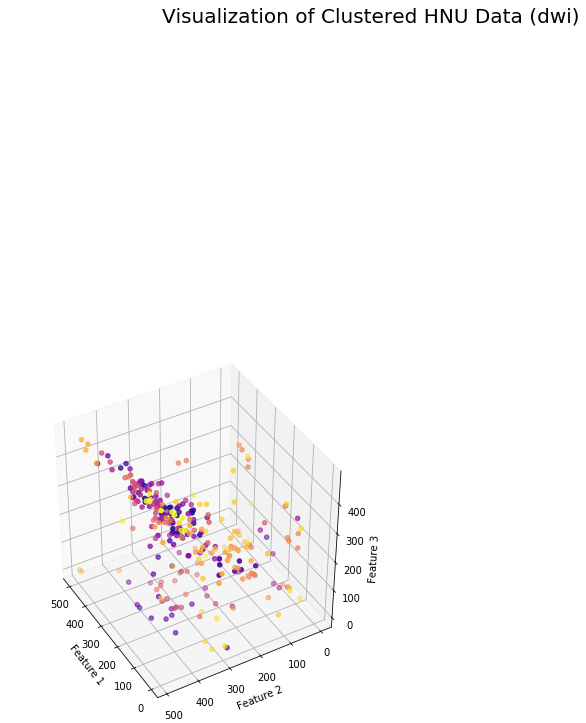

In [37]:
##### Graph the data if the features are less than 3 dimensions #####

if (numFeatures ==2):
    graph2D(mat, correctLabels)
    
if (numFeatures ==3):
    graph3D(mat, correctLabels)


In [39]:
#Cluster with affinity Propogation for multiple parameters
##### CLUSTER ######
print("AFFINITY PROPAGATION")
maxDamp, maxPre, maxSil = AffinityPropagationClustering(inputMat,.4,.1, 0, .05)
print("MINI BATCH K MEANS")
maxClusters, maxSize, maxSil = MiniBatchKMeansClustering(mat, 0, 10, 40, 50)

AFFINITY PROPAGATION
|Preference | 0.05 | Damping |  0.5 | Clusters |  72 | Silhouette |  0.100 |
|Preference | 0.05 | Damping |  0.6 | Clusters |  71 | Silhouette |  0.100 |
|Preference | 0.05 | Damping |  0.7 | Clusters |  71 | Silhouette |  0.100 |
|Preference | 0.05 | Damping |  0.8 | Clusters |  71 | Silhouette |  0.100 |
|Preference | 0.05 | Damping |  0.9 | Clusters |  73 | Silhouette |  0.095 |
|Preference | 0.10 | Damping |  0.5 | Clusters |  96 | Silhouette |  0.087 |
|Preference | 0.10 | Damping |  0.6 | Clusters |  96 | Silhouette |  0.087 |
|Preference | 0.10 | Damping |  0.7 | Clusters |  96 | Silhouette |  0.086 |
|Preference | 0.10 | Damping |  0.8 | Clusters |  96 | Silhouette |  0.086 |
|Preference | 0.10 | Damping |  0.9 | Clusters |  93 | Silhouette |  0.086 |
|Preference | 0.15 | Damping |  0.5 | Clusters |  140 | Silhouette |  0.074 |
|Preference | 0.15 | Damping |  0.6 | Clusters |  141 | Silhouette |  0.075 |
|Preference | 0.15 | Damping |  0.7 | Clusters |  145

|BatchSize | 190.00 | Clusters |  160.0 | Silhouette |  0.308 |
|BatchSize | 240.00 | Clusters |  160.0 | Silhouette |  0.304 |
|BatchSize | 290.00 | Clusters |  160.0 | Silhouette |  0.301 |
|BatchSize | 340.00 | Clusters |  160.0 | Silhouette |  0.296 |
|BatchSize | 90.00 | Clusters |  170.0 | Silhouette |  0.221 |
|BatchSize | 140.00 | Clusters |  170.0 | Silhouette |  0.296 |
|BatchSize | 190.00 | Clusters |  170.0 | Silhouette |  0.284 |
|BatchSize | 240.00 | Clusters |  170.0 | Silhouette |  0.291 |
|BatchSize | 290.00 | Clusters |  170.0 | Silhouette |  0.295 |
|BatchSize | 340.00 | Clusters |  170.0 | Silhouette |  0.294 |
|BatchSize | 90.00 | Clusters |  180.0 | Silhouette |  0.227 |
|BatchSize | 140.00 | Clusters |  180.0 | Silhouette |  0.283 |
|BatchSize | 190.00 | Clusters |  180.0 | Silhouette |  0.277 |
|BatchSize | 240.00 | Clusters |  180.0 | Silhouette |  0.274 |
|BatchSize | 290.00 | Clusters |  180.0 | Silhouette |  0.284 |
|BatchSize | 340.00 | Clusters |  180.0 | 

In [40]:
##### isolate best clustering output and create a sorted similarity matrix ####

# cluster using the best affinity propagation output
af = AffinityPropagation(damping = maxDamp, preference = maxPre,affinity="precomputed").fit(inputMat)
cluster_centers_indices = af.cluster_centers_indices_
labels_best_af = af.labels_
n_clusters_af = len(cluster_centers_indices)


# cluster using the best mini batch k means output
mb = MiniBatchKMeans(n_clusters= maxClusters, batch_size = maxSize).fit(mat)
cluster_centers_ = mb.cluster_centers_
labels_best_mb = mb.labels_
n_clusters_mb = len(cluster_centers_)


#create a dictionary of labels and nodes
nodeDict = dict(enumerate(labels_best_af))
#sort the nodes so that they are grouped by cluster label
s = sorted(nodeDict, key=nodeDict.get)

#create a sorted similarity matrix
sortedSimMat = np.empty((len(s), len(s)))
for i in range(0, len(s)):
    node = s[i]
    for j in range(0,len(s)):
        node2 = s[j]
        sortedSimMat[i][j] = inputMat[node, node2]

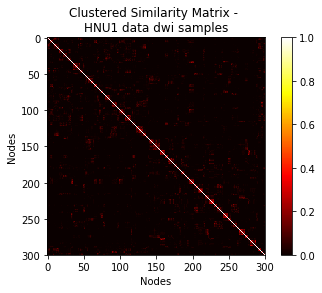

In [41]:
#create a heat map of the sorted similarity matrix
plt.figure(1)
im = plt.imshow(sortedSimMat, cmap='hot', interpolation='nearest')
cbar = plt.colorbar(im) 
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.title("Clustered Similarity Matrix - \nHNU1 data dwi samples")
plt.show()

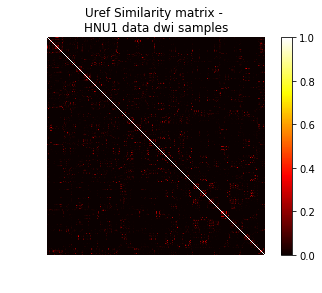

In [42]:
#create a heat map of the Urerf Similarity Matrix
plt.figure(2)
im = plt.imshow(inputMat, cmap='hot', interpolation='nearest')
cbar = plt.colorbar(im) 
plt.xlabel('Graphs')
plt.ylabel('Graphs')
plt.title("Uref Similarity matrix - \nHNU1 data dwi samples")
plt.axis('off')
plt.show()

AFFINITY PROPAGATION
Number of Clusters =  72
Accuracy 0.0166666666667


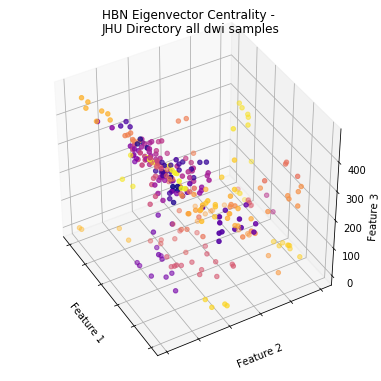

In [52]:
###### Create a plot of the clusters color-coded as such ######
from sklearn.metrics import accuracy_score
print('AFFINITY PROPAGATION')
if (numFeatures ==2):
    graph2DLabels(mat,labels_best_af)
if (numFeatures ==3):
    graph3DLabels(mat,labels_best_af)
print("Number of Clusters = ", n_clusters_af)
print("Accuracy", accuracy_score(labels_best_af, correctLabels))

MINI BATCH K MEANS
Number of Clusters =  70
Accuracy 0.0266666666667


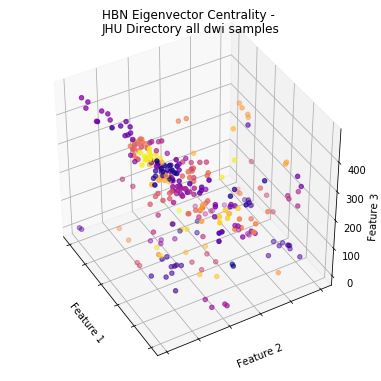

In [53]:
###### Create a plot of the clusters color-coded as such ######
print('MINI BATCH K MEANS')
if (numFeatures ==2):
    graph2DLabels(mat,labels_best_mb)

if (numFeatures ==3):
    graph3DLabels(mat,labels_best_mb)
print("Number of Clusters = ", n_clusters_mb)
print("Accuracy", accuracy_score(labels_best_mb, correctLabels))

In [54]:
##### Compare the two Algorithms #####
print("Accuracy", accuracy_score(labels_best_mb, labels_best_af))
print(labels_best_af)
print(labels_best_mb)

Accuracy 0.02
[ 0 69  1  4 34 35 34  4 69 29  2  3 13  0  0  3 22 29 29 29  8  4  9 19  6
 20  5  6  7  8 15  9 27 30 53 23 27 23 27 25 10 12 12 65 11 11 11 12 13 14
 39 15 15 16 17 16 16 56 17 16 59 70 28 18 20 23 23 19 20 60 21  5 28 22 56
 23  2 24 62  8 19 38 15 53 25 36 62 56  5 26 27 49 28 27 31 29 28  4  1  9
 36 52 45 64 30 62 39 64 64 39 31 47 43 32 46 54 41 31  1 32 25 33 33 70 34
 35 35 21 34 34 47  7 36 37 46 43  6  6 18 41  3 38 38 39 16 33 38  0 38 39
 59 40 42 49 59  1 18 49 41 49 18 41 41 42 42 40 42 43 31 42 25 26 40 45 44
 39 26 54 62 45 49 23 68 46 37 47 42 17 42 23 67 48 67  6 67 48 55 40 49 55
 29 50 52 50 51 52 52 14 52 53 67 55 54 66 66 55 54 64 55 40 56 58 39 51 57
 57 57 50 58 58 13 10 64 22 61 44 11 24 24 10 59 59 59 55 68 60 60 59 66 60
 61 54 52 62 63 58 14 46 61 51 63 67 45 58 71 46  8  5  5 63 17 64 65 65 65
 64 52 39 39 64 40 55 40 66 42 67 67 43 68 48 71 25 25 69 35 69 29 70 34 71]
[25  1 42  1 68  1 68  1  1 44 15 25 25 25 25 25 12  1 44 44 15  1 13 15 